In [30]:
'Read in all required packages'
import pandas as pd
import numpy as np
import shap
import sklearn
import xgboost as xgb
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
data = pd.read_csv('cirrhosis.csv')

In [32]:
data.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [33]:
def summary(frame):
    summ = pd.DataFrame(frame.dtypes, columns = ['Data Types'])
    missing_values = frame.isna().sum()
    summ['#missing_values'] = missing_values
    summ['%missing_values'] = missing_values / frame.shape[0]
    summ['#unique_values'] = frame.nunique()
    describe = frame.describe().T
    return pd.concat([summ, describe],axis = 1)

In [34]:
summary(data)

,Data Types,#missing_values,%missing_values,#unique_values,count,mean,std,min,25%,50%,75%,max
ID,int64,0,0.000000,418,418.0,209.500000,120.810458,1.00,105.2500,209.50,313.75,418.00
N_Days,int64,0,0.000000,399,418.0,1917.782297,1104.672992,41.00,1092.7500,1730.00,2613.50,4795.00
Status,object,0,0.000000,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Drug,object,106,0.253589,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,int64,0,0.000000,344,418.0,18533.351675,3815.845055,9598.00,15644.5000,18628.00,21272.50,28650.00
Sex,object,0,0.000000,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ascites,object,106,0.253589,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hepatomegaly,object,106,0.253589,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Spiders,object,106,0.253589,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Edema,object,0,0.000000,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
num_cols = data.select_dtypes(include = [int, float]).columns.to_list()
num_cols.remove('ID')
num_cols.remove('Stage')
cat_cols = data.select_dtypes(include = [object]).columns.to_list()
cat_cols.remove('Status')
cat_cols.append('Stage')
target = 'Status'

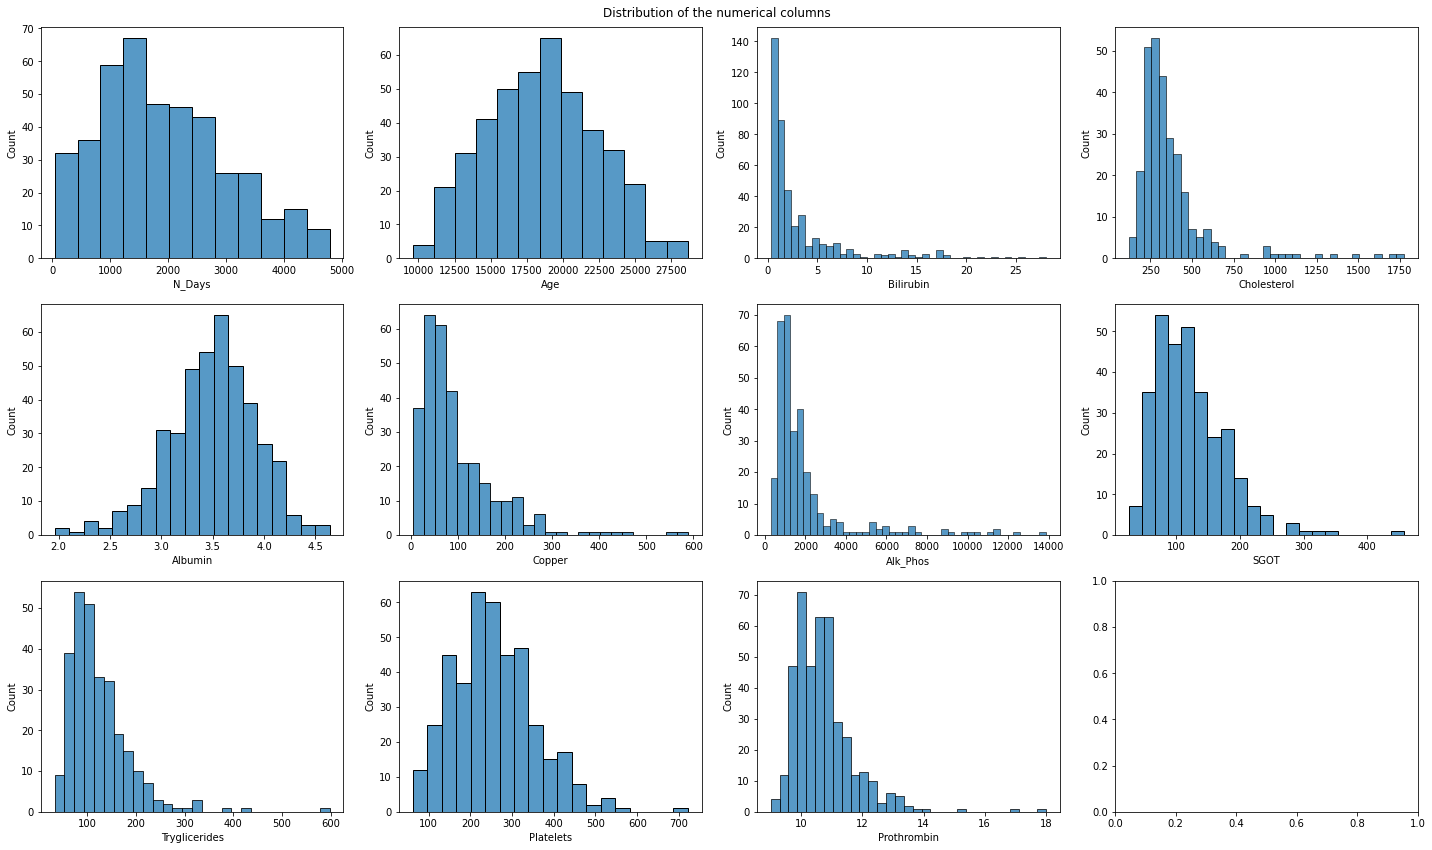

In [36]:
ncols = 4
nrows = int(np.ceil(len(num_cols) / ncols))

fig, ax = plt.subplots(ncols = ncols, nrows = nrows, figsize = (20, 4*nrows))
ax = ax.flatten()

for fold, col in enumerate(num_cols):
    sns.histplot(data = data, x = col, ax = ax[fold])
    
    

plt.suptitle('Distribution of the numerical columns')
plt.tight_layout()
plt.show()

In [37]:
'Here we drop all rows with missing values, plus also drop the ID and column and those with a status of CL'
data = data.dropna()
data = data.drop(['ID'] ,axis = 1)
data = data[data.Status != 'CL']

In [38]:
'We isolate the target column and drop it from the mai dataset'
y = data['Status']
X = data.drop(['Status'],axis = 1)

In [39]:
'We need to convert the categorical variables into binary outcomes for future calculations '
X = pd.get_dummies(X,dtype=float)

In [40]:
X.head()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,...,Sex_M,Ascites_N,Ascites_Y,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,Spiders_Y,Edema_N,Edema_S,Edema_Y
0,400,21464,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,4500,20617,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,1012,25594,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,1925,19994,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
6,1832,20284,1.0,322.0,4.09,52.0,824.0,60.45,213.0,204.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


In [44]:
y

0      D
1      C
2      D
3      D
6      C
      ..
307    C
308    C
309    C
310    C
311    C
Name: Status, Length: 258, dtype: object

In [ ]:
y = y.eq('').mul(1)

In [41]:
'We split the dataframe into train and test sets in order to assess feature importance'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

In [43]:
'We fit a gradient boosted tree to indentify the most important features in the dataset'
xgb_model = XGBClassifier(n_estimators=1000, max_depth=10, learning_rate=0.001, random_state=0, verbose = 1)
xgb_model.fit(X_train, y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


ImportError: cannot import name 'Int64Index' from 'pandas' (/Users/thomasrowe/.local/share/virtualenvs/Dev-fNV4jyM8/lib/python3.8/site-packages/pandas/__init__.py)

In [ ]:
' Here we develop the shap values and output them to a diagrame for inspection'
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns)

In [ ]:
'We can see that the bottom 7 or 8 features are not useful for prediction, therefore they are removed from the dataset '
X = X.drop(['Sex_F','Albumin','Drug_D-penicillamine','Edema_S','Drug_Placebo','Sex_M','Ascites_N',
           'Ascites_Y','Hepatomegaly_N'], axis = 1)

In [ ]:
X

In [ ]:
skf=StratifiedKFold(n_splits=5)
model_AUC = []
AUC = []
final = []
LR = LogisticRegression()
RF = RandomForestClassifier()
DC = DecisionTreeClassifier()
GB = XGBClassifier()
Models = [LR,RF,DC,GB]

for c in Models:
    
    model_AUC = []
    for train_index, test_index in skf.split(X,y):
        train_x,test_x= X.iloc[train_index],X.iloc[test_index]
        train_y,test_y= y.iloc[train_index],y.iloc[test_index]
        c.fit(train_x,train_y)
        pred_prob = c.predict_proba(test_x)
        auc_score = roc_auc_score(test_y, pred_prob[:,1])
        model_AUC.append(auc_score)
        
    AUC.append(model_AUC)
    final.append(np.mean(AUC))

In [ ]:
AUC